In [ ]:
!pip install mne
!pip install tensorflow==2.9.1

In [1]:
import tensorflow as tf
print(tf.__version__)
from mne.decoding import CSP

2.9.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import clear_output
#import pywt
import numpy as np
#import imageio
import tensorflow as tf
#import cv2
#import time
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report
import os
#from scipy import signal
#from sklearn import preprocessing
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetTrainSub1_30.csv', delimiter=";")
test_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetTestSub1_30.csv', delimiter=";")
val_data = pd.read_csv('/content/drive/MyDrive/TCC-Physionet/PhysionetValSub1_30.csv', delimiter=";")


In [58]:
labels = {'0': 'rest', '1': 'left', '2': 'right'}
selected_eletrodes = list(train_data['eletrodo'].unique())
 #['C3', 'CZ', 'C4']
 #
 #['F3', 'F4', 'F5', 'F6', 'FC5', 'FC3','FC4', 'FC6', 'C5', 'C3', 'C4', 'C6']

In [59]:
# y_delta = butter_bandpass_filter(signal, 0.1, 4, 160, order=5)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


In [60]:
def metrics_zscore(data, selected_eletrodes):
  std = []
  mean = []
  for eletrode in selected_eletrodes:
    eletrodoStd = pd.Series(data.loc[data["eletrodo"] == eletrode, "leitura0":"leitura639"].values.ravel('F')).std()
    eletrodoMean = pd.Series(data.loc[data["eletrodo"] == eletrode, "leitura0":"leitura639"].values.ravel('F')).mean()
    std.append(eletrodoStd)
    mean.append(eletrodoMean)

  return std, mean

In [62]:
def assemble_data(data, selected_eletrodes, std_el, mean_el):
  cwt_limit = 30
  widths = np.arange(1, cwt_limit + 1)
  labels = []
  signals = []
  pacients = data["paciente"].unique()
  len_selected_eletrodes = len(selected_eletrodes)

  for pacient in pacients:
      measures = data.loc[data['paciente'] == pacient]['medicao'].unique()
      for measure in measures:
          label = data.loc[(data['paciente'] == pacient) & (data['medicao'] == measure)]['label'].unique()[0]
          if label != 1:
            signal_list = []
            img = np.zeros([len_selected_eletrodes, 640])
            print(pacient,measure)
            for idx, eletrode in enumerate(selected_eletrodes):
              sign = data.loc[(data['paciente'] == pacient) & (data['medicao'] == measure) & (data['eletrodo'] == eletrode)].iloc[:,4:644].to_numpy().reshape(640)
              sign -= mean_el[idx]
              sign /= std_el[idx]
              img[idx] = sign
            '''
            img = np.zeros([64, 640])
            for i in range(64):
              img[i] = temp[i%3]
            '''
            signals.append(img)
            labels.append(label-2)


            clear_output(wait=True)

  print(np.array(signals).shape)
  print(np.array(labels).shape)
  return labels, signals


In [63]:
def assemble_csp_data(csp, signals, selected_eletrodes):
  signals_csp = []
  len_selected_eletrodes = len(selected_eletrodes)

  for sig in signals:
    csp_result = csp.transform(sig.reshape(1,64,640))[0]
    img = np.zeros([64, 640, 3])
    for i in range(len(csp_result)):
      img[:,:,i] = sig * csp_result[i]
    signals_csp.append(csp_result)

  return signals_csp


In [64]:
class PhysionetDataset:
  def __init__(self, data, selected_eletrodes, batch_size, train=True, std=None, mean=None, csp=None):
    if(train):
      self.std, self.mean = metrics_zscore(data, selected_eletrodes)
    else:
      self.std, self.mean = std, mean

    self.label, self.signal = assemble_data(data, selected_eletrodes, self.std, self.mean)
    '''
    if(train):
      print('Fit CSP')
      self.csp = CSP(n_components=8, reg=None, log=None, norm_trace=False)
      self.csp.fit_transform(np.array(self.signal), np.array(self.label))
    else:
      self.csp = csp
    '''
    print('Assemble csp_data')
    #signal_csp = assemble_csp_data(self.csp, self.signal, selected_eletrodes)
    img_generator = tf.keras.preprocessing.image.ImageDataGenerator()

    self.features = img_generator.flow(
        x=np.array(self.signal).reshape(len(self.signal), 64, 640, 1),
        y=np.array(self.label).reshape(len(self.label),1),
        batch_size=batch_size)



In [65]:
batch = 64

#TimeseriesGenerator
train_dataset = PhysionetDataset(train_data, selected_eletrodes, batch)
val_dataset = PhysionetDataset(val_data, selected_eletrodes, batch, train=False, std=train_dataset.std, mean=train_dataset.mean, csp=None)
#test_dataset = PhysionetDataset(test_data, selected_eletrodes, batch)

(63, 64, 640)
(63,)
Assemble csp_data


In [66]:
inp = layers.Input(shape=(64, 640, 1))
x = layers.Conv2D(8, (2,2), padding= 'same')(inp)
x = layers.Conv2D(16, (2,2), activation=layers.LeakyReLU(0.1), strides=(1,4))(x)
x = layers.Conv2D(32, (2,2), padding= 'same')(x)

x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(64, (2,2), activation=layers.LeakyReLU(0.1), padding= 'same')(x)
x = layers.Conv2D(128, (2,2), activation=layers.LeakyReLU(0.1), padding= 'same')(x)


x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(256, (2,2), activation=layers.LeakyReLU(0.1), padding= 'same')(x)
x = layers.Conv2D(512, (2,2), activation=layers.LeakyReLU(0.1), padding= 'same')(x)


#x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(inp, x)

In [67]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 640, 1)]      0         
                                                                 
 conv2d_72 (Conv2D)          (None, 64, 640, 8)        40        
                                                                 
 conv2d_73 (Conv2D)          (None, 63, 160, 16)       528       
                                                                 
 conv2d_74 (Conv2D)          (None, 63, 160, 32)       2080      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 31, 80, 32)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 31, 80, 32)        0         
                                                           

In [68]:

model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [69]:
#model = load_model('/content/drive/MyDrive/TCC-Physionet/model_CNNEEG.h5')

history = model.fit(train_dataset.features.x, train_dataset.features.y, epochs=50, validation_data=(val_dataset.features.x, val_dataset.features.y))#, callbacks=callbacks)

model.save('/content/drive/MyDrive/TCC-Physionet/model_CNNEEG.h5')

Epoch 1/50
10/10 [==============================] - 9s 817ms/step - loss: 0.8680 - accuracy: 0.5312 - val_loss: 0.6976 - val_accuracy: 0.4762
Epoch 2/50
10/10 [==============================] - 9s 870ms/step - loss: 0.7122 - accuracy: 0.5125 - val_loss: 0.6916 - val_accuracy: 0.4762
Epoch 3/50
10/10 [==============================] - 8s 789ms/step - loss: 0.6870 - accuracy: 0.5437 - val_loss: 0.6906 - val_accuracy: 0.5238
Epoch 4/50
10/10 [==============================] - 8s 853ms/step - loss: 0.6655 - accuracy: 0.6344 - val_loss: 0.6999 - val_accuracy: 0.5238
Epoch 5/50
10/10 [==============================] - 8s 807ms/step - loss: 0.6280 - accuracy: 0.6500 - val_loss: 0.6921 - val_accuracy: 0.6190
Epoch 6/50
10/10 [==============================] - 8s 817ms/step - loss: 0.5441 - accuracy: 0.7250 - val_loss: 0.8994 - val_accuracy: 0.5714
Epoch 7/50
10/10 [==============================] - 8s 840ms/step - loss: 0.5089 - accuracy: 0.7531 - val_loss: 0.7207 - val_accuracy: 0.6984
Epoch 

In [ ]:
model = load_model('/content/drive/MyDrive/TCC-Physionet/model_CNNEEG.h5')

history = model.fit(train_dataset.features.x, train_dataset.features.y, epochs=20,
                    validation_data=(val_dataset.features.x, val_dataset.features.y))#, callbacks=callbacks)

model.save('/content/drive/MyDrive/TCC-Physionet/model_CNNEEG.h5')

In [70]:
test_dataset = PhysionetDataset(test_data, selected_eletrodes, batch, train=False, std=train_dataset.std, mean=train_dataset.mean)

(67, 64, 640)
(67,)
Assemble csp_data


In [71]:
score = model.evaluate(test_dataset.features.x, test_dataset.features.y, verbose=0)
print('Loss: ', score[0])
print('Accuracy: ', score[1])

Loss:  2.4385745525360107
Accuracy:  0.7611940503120422


In [ ]:
inp = layers.Input(shape=(64, 800, 1))
x = layers.Conv2D(256, (2,2), activation='relu')(inp)
x = layers.Conv2D(256, (2,2), activation='relu')(x)

x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(512, (2,2), activation='relu')(x)
x = layers.Conv2D(512, (2,2), activation='relu')(x)

x = layers.MaxPool2D((2,2))(x)

x = layers.TimeDistributed(layers.LSTM(256, return_sequences=True))(x)
x = layers.TimeDistributed(layers.LSTM(128, return_sequences=True))(x)
x = layers.TimeDistributed(layers.LSTM(64, return_sequences=True))(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(inp, x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
print(__doc__)


Automatically created module for IPython interactive environment


In [ ]:
#print(epochs_data.shape)
#print(labels.shape)
#type(labels)

(29, 64, 801)
(29,)


numpy.ndarray

In [ ]:
data = np.array(train_dataset.signal)
print(data.shape)
lb = np.array(train_dataset.label)
print(lb.shape)

(471, 64, 640)
(471,)


In [ ]:
csp = CSP(n_components=64, reg=None, norm_trace=False)
retorno = csp.fit_transform(data, lb)

print(retorno.shape)

Computing rank from data with rank=None
    Using tolerance 29 (2.2e-16 eps * 64 dim * 2e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 28 (2.2e-16 eps * 64 dim * 2e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 26 (2.2e-16 eps * 64 dim * 1.8e+15  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
(471, 64, 640)


In [ ]:
retorno.shape

(471, 3)

In [ ]:
csp.patterns_.shape

In [ ]:
csp.filters_.shape
data[0].reshape(1,64,640)

(64, 640)

In [ ]:
x_transform = csp.transform(data[0].reshape(1,64,640))

In [ ]:
x_transform

array([[-1.77886019, -1.5291702 , -1.09153383]])

In [ ]:
channels = ['FC5','FC3','FC1','FCz','FC2','FC4','FC6','C5','C3','C1','Cz','C2','C4','C6','CP5','CP3','CP1','CPz','CP2',
 'CP4','CP6','Fp1','Fpz','Fp2','AF7','AF3','AFz','AF4','AF8','F7','F5','F3','F1','Fz','F2','F4','F6','F8','FT7','FT8','T7',
 'T8','T9','T10','TP7','TP8','P7','P5','P3','P1','Pz','P2','P4','P6','P8','PO7','PO3','POz','PO4','PO8','O1','Oz','O2','Iz']

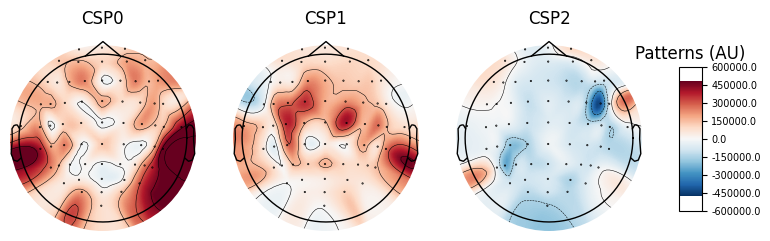

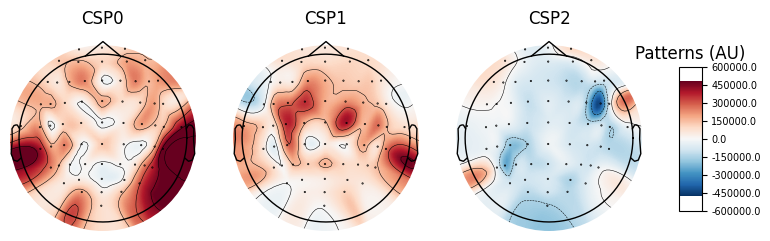

In [ ]:
info = create_info(channels, 160, ch_types='eeg', verbose=None)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [ ]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(rest=1,left=2, right=3)
subject = 1
runs = [3]

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)


In [ ]:
# Apply band-pass filter
#raw.filter(2.0, 10.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = events_from_annotations(raw, event_id='auto')
print(events)
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")


Used Annotations descriptions: ['T0', 'T1', 'T2']
[[    0     0     1]
 [  672     0     3]
 [ 1328     0     1]
 [ 2000     0     2]
 [ 2656     0     1]
 [ 3328     0     2]
 [ 3984     0     1]
 [ 4656     0     3]
 [ 5312     0     1]
 [ 5984     0     3]
 [ 6640     0     1]
 [ 7312     0     2]
 [ 7968     0     1]
 [ 8640     0     2]
 [ 9296     0     1]
 [ 9968     0     3]
 [10624     0     1]
 [11296     0     2]
 [11952     0     1]
 [12624     0     3]
 [13280     0     1]
 [13952     0     3]
 [14608     0     1]
 [15280     0     2]
 [15936     0     1]
 [16608     0     2]
 [17264     0     1]
 [17936     0     3]
 [18592     0     1]
 [19264     0     2]]


In [ ]:
# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 801 original time points ...
1 bad epochs dropped


In [ ]:
epochs.info

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>

In [ ]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=3, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# plot CSP patterns estimated on full data for visualization
retorno = csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [ ]:
print(len(epochs_data),len(epochs_data[0]), len(epochs_data[0][0]))
print(labels)

29 64 801
[ 1 -1  0 -1  0 -1  1 -1  1 -1  0 -1  0 -1  1 -1  0 -1  1 -1  1 -1  0 -1
  0 -1  1 -1  0]


In [ ]:
print(len(retorno))
print(len(retorno),len(retorno[0]))
print(retorno)

In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])
    print(len(X_test), len(X_test[0]), X_test[0][0])
    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [ ]:
parametros = csp.get_params(True)

In [ ]:
parametros

{'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 12,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'}

In [ ]:
len(epochs_data_train)

29

In [ ]:
len(epochs_data_train[0])

64

In [ ]:
len(epochs_data_train[0][0])

161

In [ ]:
cv_split = cv.split(epochs_data_train)


for train_idx, test_idx in cv_split:
  print(test_idx)
  print('-------------')
  X_test = csp.transform(epochs_data_train[train_idx])
  print(len(X_test))
  print(len(X_test[0]))


[27 16 12 22  8  9]
-------------
23
12
[ 0  5 20 25 13  7]
-------------
23
12
[ 4 24 10  0  8 19]
-------------
23
12
[ 3  1  4  5 16 25]
-------------
23
12
[14  3 27 19 24 21]
-------------
23
12
[17 11  7 13  0 27]
-------------
23
12
[14 13 18 15  9 26]
-------------
23
12
[ 9  8  7 12  3 14]
-------------
23
12
[12 14 21 20  6  7]
-------------
23
12
[13 14 15 25  4 20]
-------------
23
12


In [ ]:
print(len(epochs_data_train), len(epochs_data_train[0]))

29 64


In [ ]:
epochs_data_train.shape()

TypeError: ignored